#Velocity (slowness) models

The tomography code can jointly solve for updates to (1) a 2D or 3D Cartesian slowness model grid and (2) layer interface depths.  This notebook shows how to use PyVM tools to build and manipulate models in this format.

##Building a basic model

###(1) Define the model domain

This initalizes a new model, with a slowness grid with 0 everywhere and no layer boundaries.

Populating the interactive namespace from numpy and matplotlib
============================Slowness Model============================
20000-node cartesian grid:
x-range: [0, 99.5] (nx = 200, dx = 0.5)
y-range: [0, 0] (ny = 1, dy = 1)
z-range: [0, 24.75] (nz = 100, dz = 0.25)
 values: min = 0, mean = 0, max = 0
============================Slowness Model============================
[Use 'print(VM.__str__(extended=True))' for more detailed information]


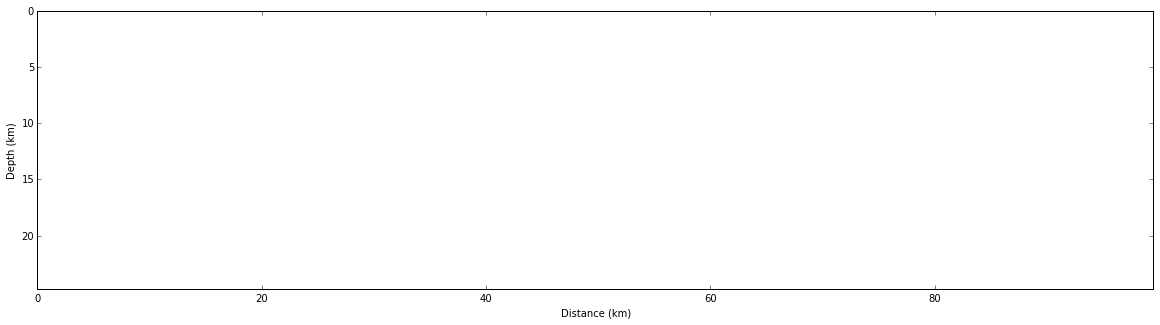

In [70]:
% pylab inline
import matplotlib.pyplot as plt
from pyvm.models.vm import VM

# define the model domain in terms of grid dimensions, spacing, and origin
vm = VM(shape=(200, 1, 100), spacing=(0.5, 1, 0.25), origin=(0, 0, 0))

# print a summary of model
print(vm)

# plot
vm.plot(figsize=(20, 10), show=False)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')

###(2) Add some layers

New layers can be added using the tool `vm.insert_interface()`:

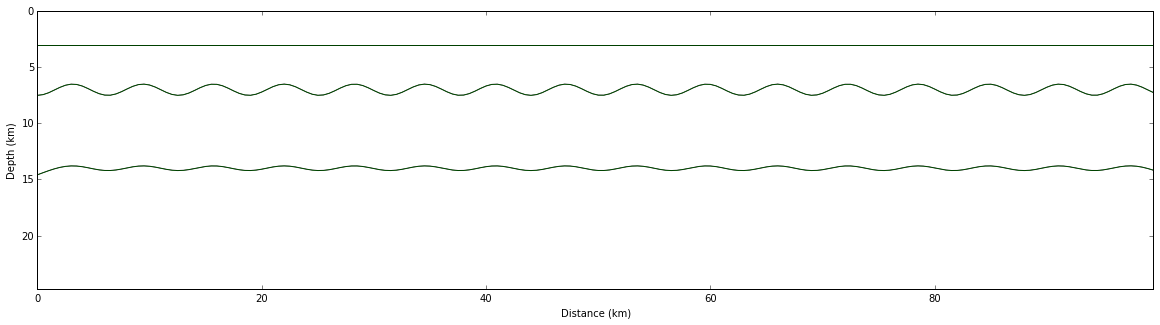

In [71]:
import numpy as np

# add a layer with a constant depth
vm.insert_interface(3)

# add a variable depth interface
z = np.reshape(7 + 0.5 * np.cos(vm.grid.x), (vm.nx, 1))
vm.insert_interface(z)

# offset the 2nd interface and smooth it
vm.insert_interface(vm.rf[1] + 7.)
vm.smooth_interface(2, nwin=15)

# plot
vm.plot(figsize=(20, 10), show=False)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')

###(3) Define velocities

Velocities can be defined within layers using tools with names like `vm.define_constant_layer_gradient()`.  Here are some examples:

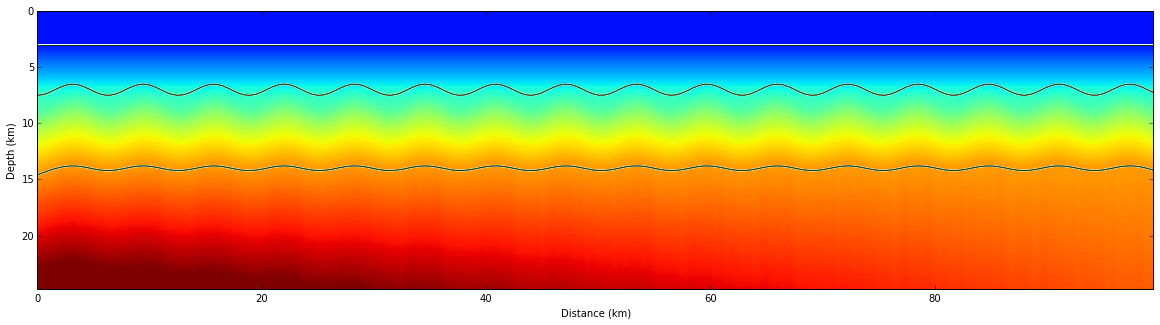

In [72]:
# flood the first layer with a constant velocity
vm.define_constant_layer_velocity(0, 1.5)

# define 0.5 km/s per km gradient in the second layer
vm.define_constant_layer_gradient(1, 0.5)

# stretch a 1D velocity function to fit between the 2nd and 3rd interfaces
# Note: using `None` as the first value means that the velocity should start at the bottom velocity
# of the overlying layer
vm.define_stretched_layer_velocities(2, [None, 4., 4.8, 5.5, 6.0, 6.5])

# define a gradient that varies in the x-dimension for the 4th layer
dvdz = np.reshape((0.05 + 0.002 * (vm.grid.x - vm.r1[0]))[::-1], (vm.nx, 1))
vm.define_variable_layer_gradient(3, dvdz)


# plot
vm.plot(figsize=(20, 10), show=False)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')

###(4) Set slowness jumps

The tomographic inversion requires that the slowness vary smoothly. The include sharp jumps in velocity across layer interfaces, the inversion also solves for "slowness jumps" on each interface.  These jumps can be applied to the grid and removed with:

    vm.apply_jumps()
    vm.remove_jumps()

By default, the jumps are all zeros to start:

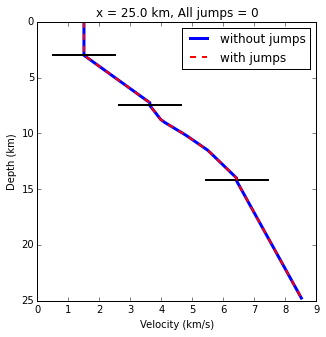

In [73]:
# plot single profile
ix = 50

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(1. / vm.sl[ix, 0, :], vm.grid.z, '-b', lw=3, label='without jumps')

for iref in range(vm.nr):
    zb = vm.rf[iref, ix, 0]
    vb = 1. / vm.sl[ix, 0, vm.grid.z2i(zb)[0]]
    ax.plot([vb - 1., vb + 1.], [zb, zb], '-k', lw=2)

vm.apply_jumps()
ax.plot(1. / vm.sl[ix, 0, :], vm.grid.z, '--r', lw=2, label='with jumps')
vm.remove_jumps()

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Velocity (km/s)')
plt.ylabel('Depth (km)')
plt.title('x = {:} km, All jumps = 0'.format(vm.grid.x[ix]))

Jumps can be defined manually by changing values in the `vm.jp` array:

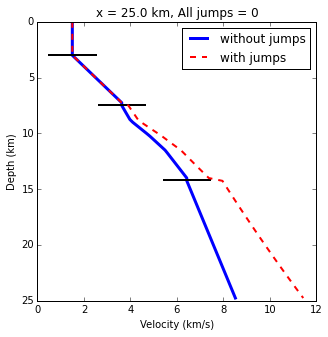

In [74]:
# add a jump across the 1st boundary
vm.jp[1] = -0.02 * np.ones((vm.nx, vm.ny))

# add a ~0.5 km/s jump across the 3rd boundary
vm.jp[2] = -0.01 * np.ones((vm.nx, vm.ny))


# replot single profile
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# before applying jumps to the grid
ax.plot(1. / vm.sl[ix, 0, :], vm.grid.z, '-b', lw=3, label='without jumps')

for iref in range(vm.nr):
    zb = vm.rf[iref, ix, 0]
    vb = 1. / vm.sl[ix, 0, vm.grid.z2i(zb)[0]]
    ax.plot([vb - 1., vb + 1.], [zb, zb], '-k', lw=2)

vm.apply_jumps()
ax.plot(1. / vm.sl[ix, 0, :], vm.grid.z, '--r', lw=2, label='with jumps')
vm.remove_jumps()

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Velocity (km/s)')
plt.ylabel('Depth (km)')
plt.title('x = {:} km, All jumps = 0'.format(vm.grid.x[ix]))

Here's what the jumps look like on the entire grid:

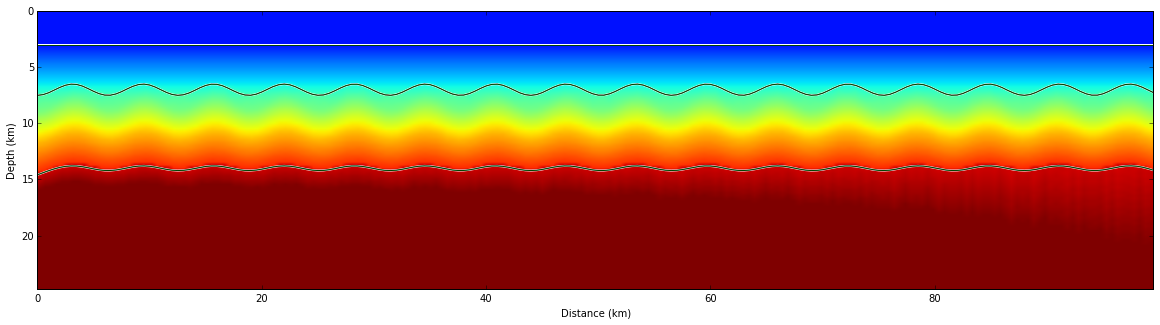

In [75]:
vm.plot(figsize=(20, 10), show=False)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')